# Imports

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

from sklearn.preprocessing import normalize

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_squared_error

In [221]:
data = pd.read_csv('Data/training_1.csv')
data2 = pd.read_csv('Data/training_2.csv')
data3 = pd.read_csv('Data/test.csv')

data2.columns = data2.columns.str.replace(' ', '')

# Familiarization task – 1 A4 

Answer the following questions:
* What kinds of signals are there?
* Are the signals correlated? Do they show cyclic behavior?
* Is predicting the next value in a series easy or hard? Use any method from class.

Visualize these types, the presence or absence of correlation, and the performance of prediction.

TODOS:
* Little bit more about cyclic behaviour
* Draw conclusions from predictions

### What kinds of signals are there?

The data is categorized as follows:
* T Are the water tanks
    * L_Tx stands for the water level in the tanks (float)
* PU Are the pumps
    * F_PUx(x) stands for the flow through the pumt(float)
    * S_PUx(x) stands for the status of the pump (on (1) / off (0)) (binary)
* V is a valve
    * F_Vx stands for flow through the valve (float) 
    * S_Vx stands for the status of the valve (open (1) / closed (0)) (binary)
* J are junctions
    * P_Jxxx stands for the pressure in the junction (float)

* ATT_FLAG is the attack flag (normal (0) / attack (1) / unknown (-999))

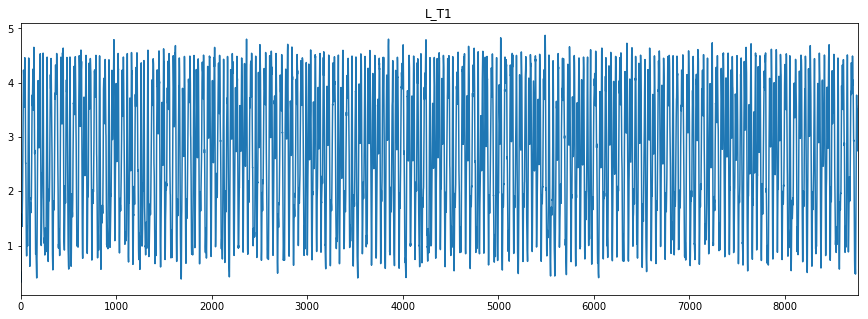

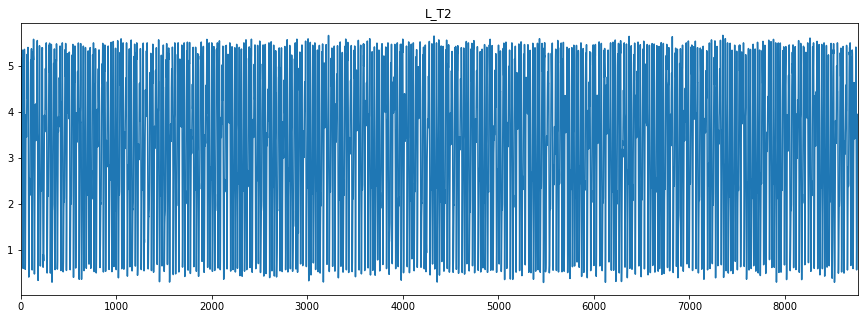

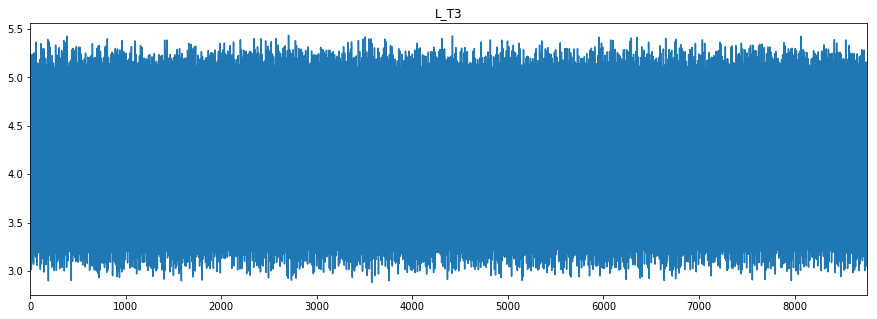

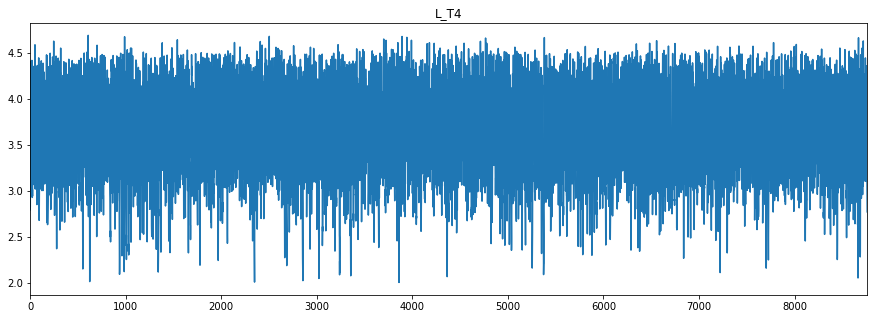

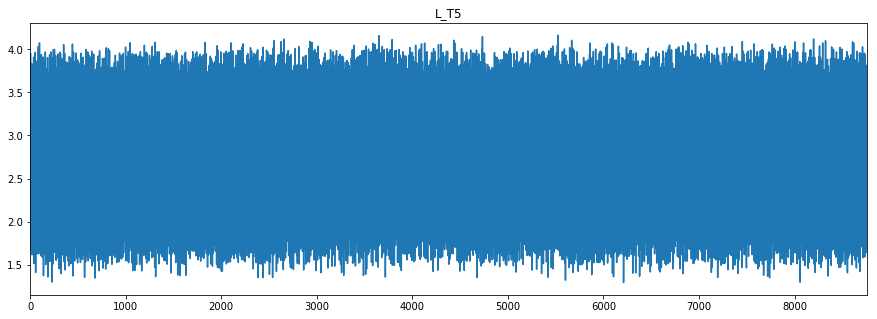

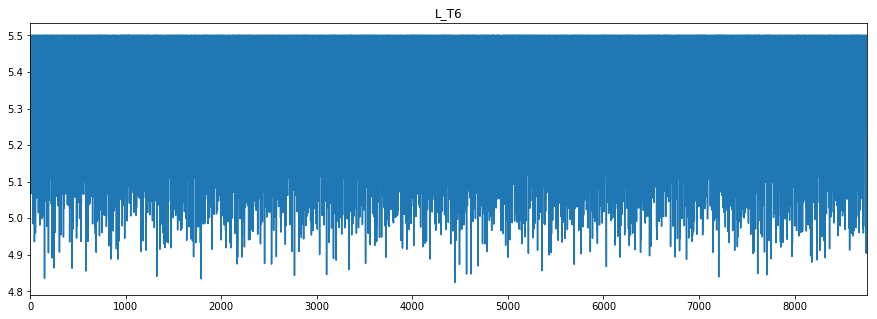

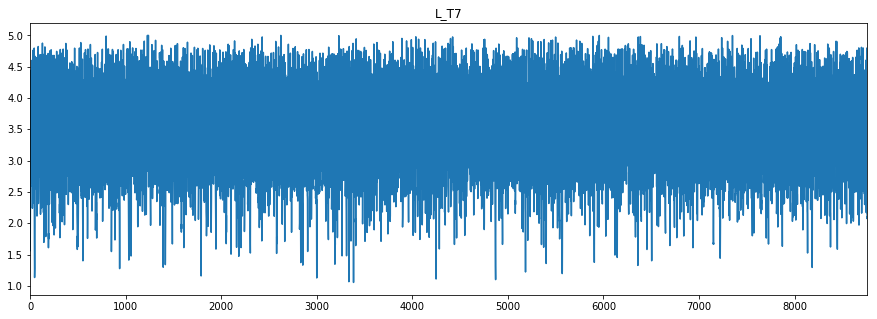

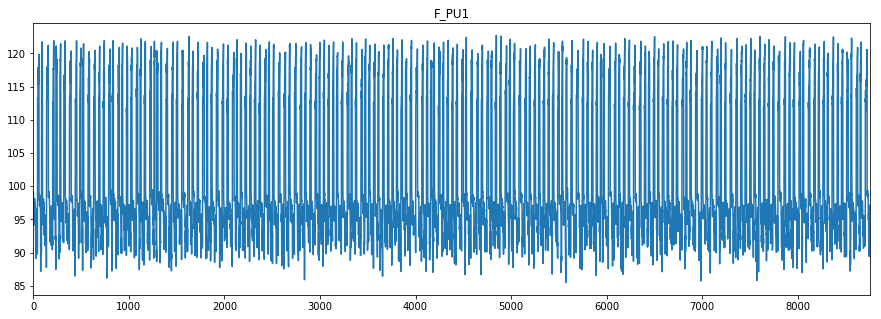

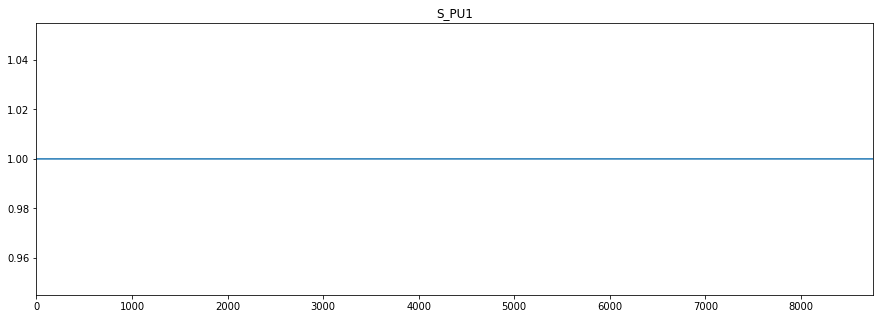

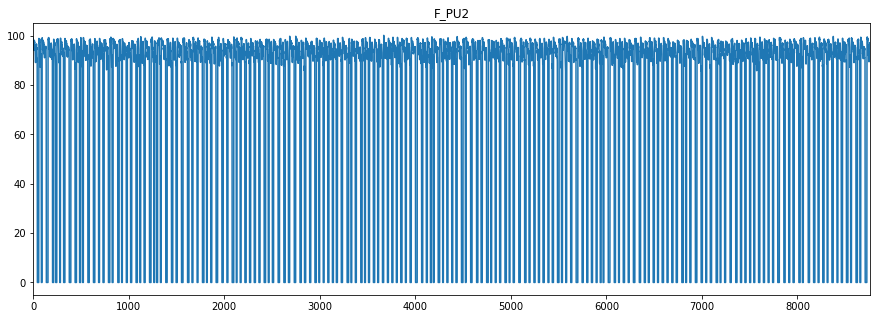

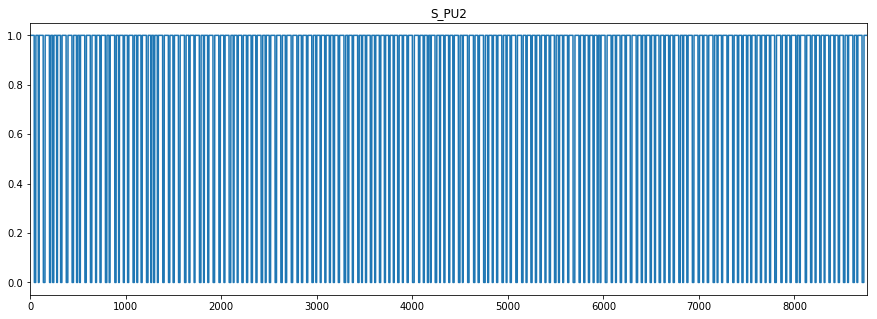

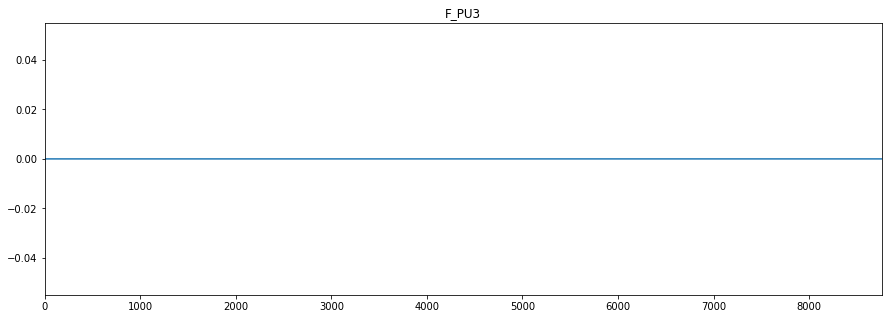

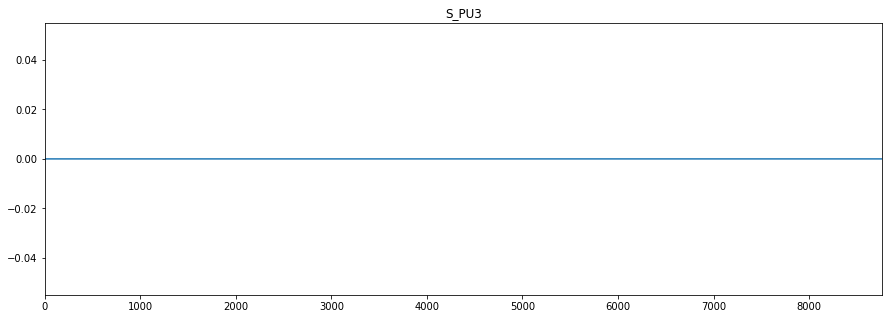

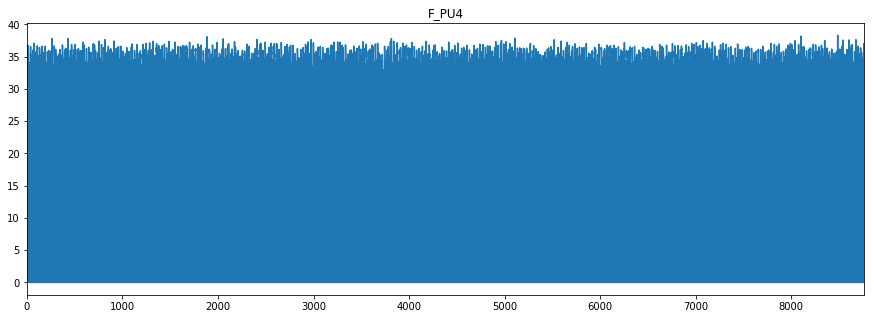

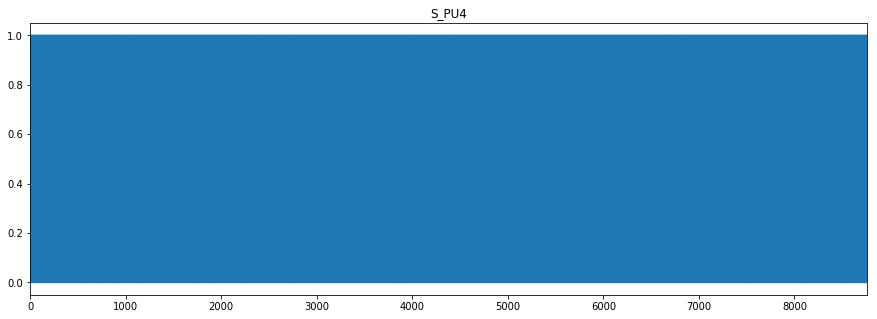

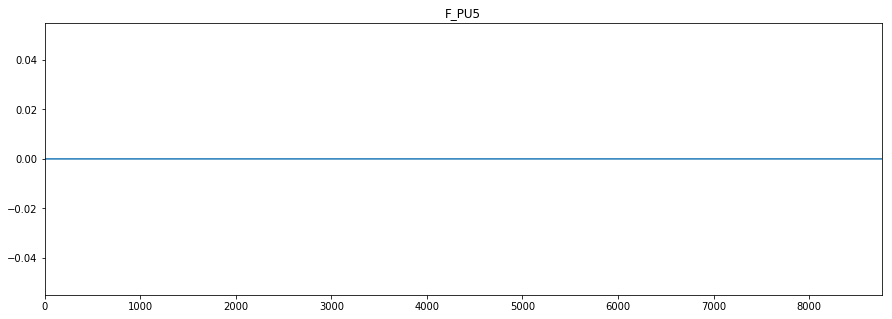

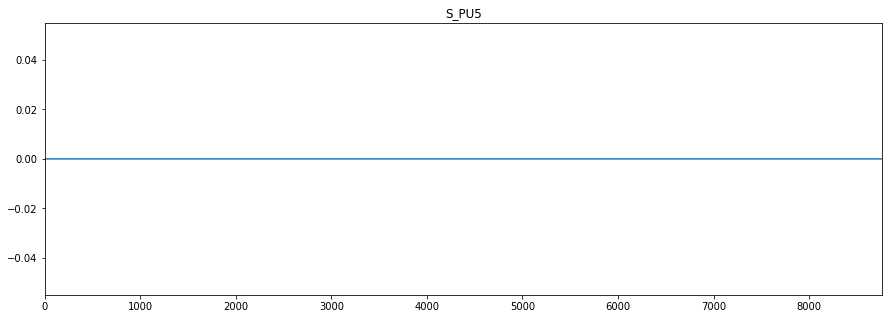

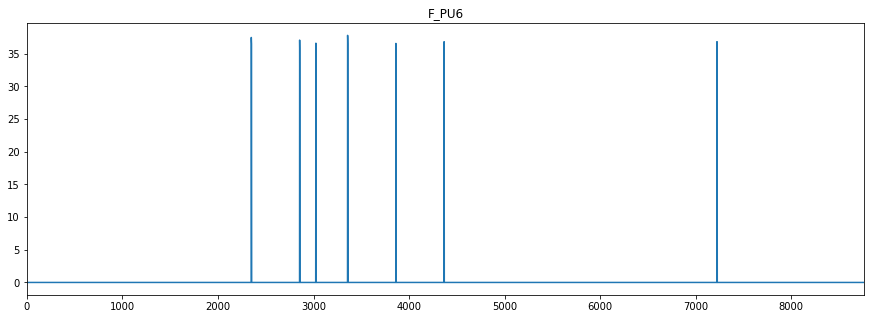

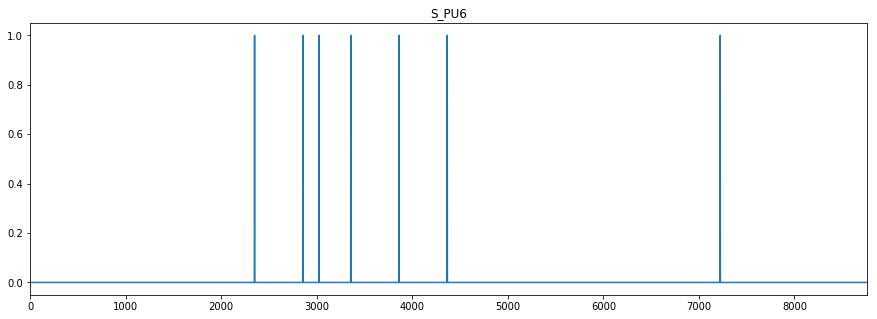

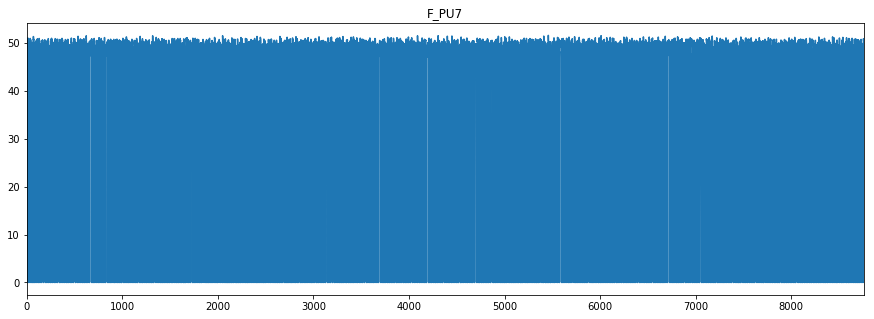

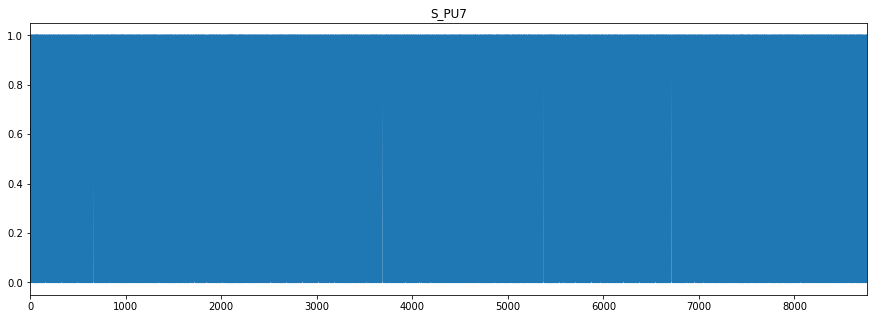

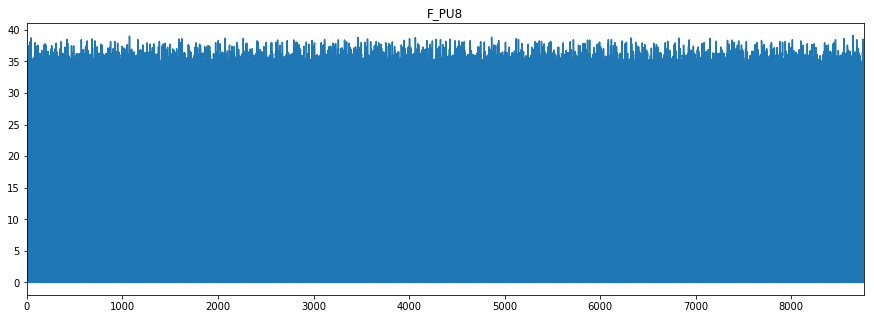

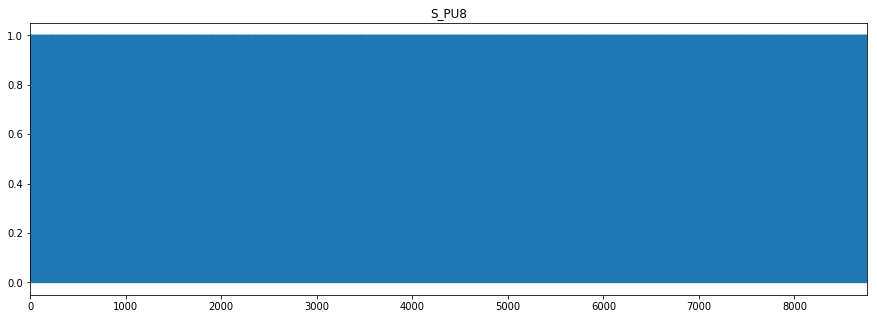

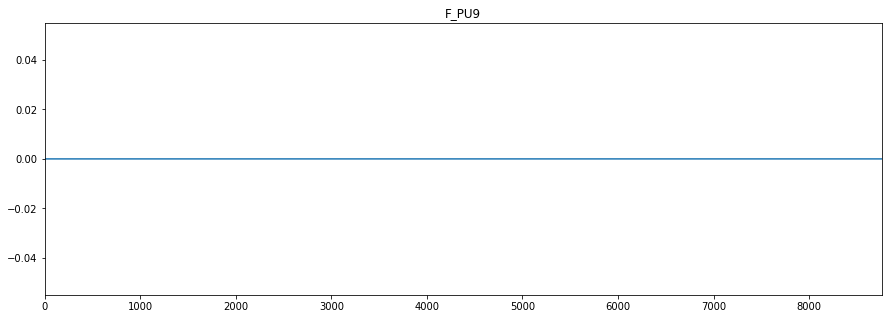

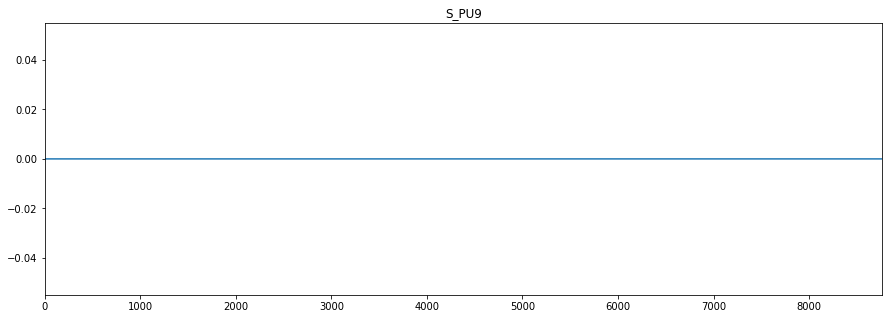

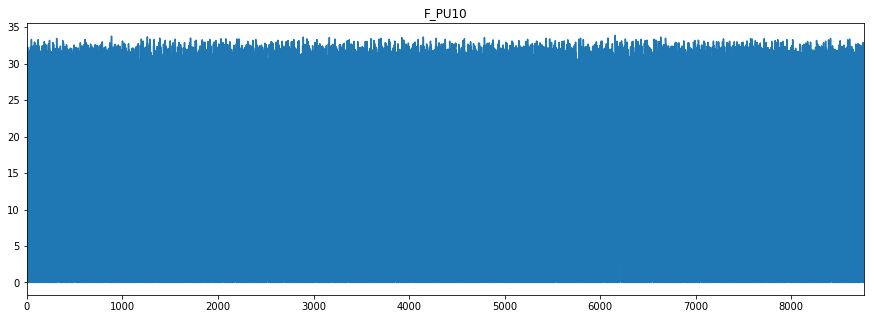

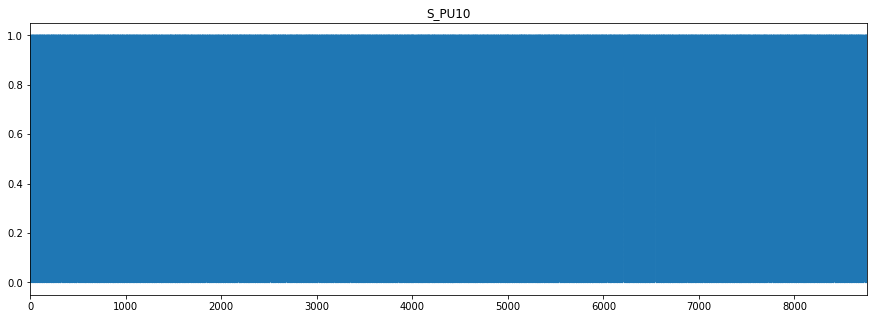

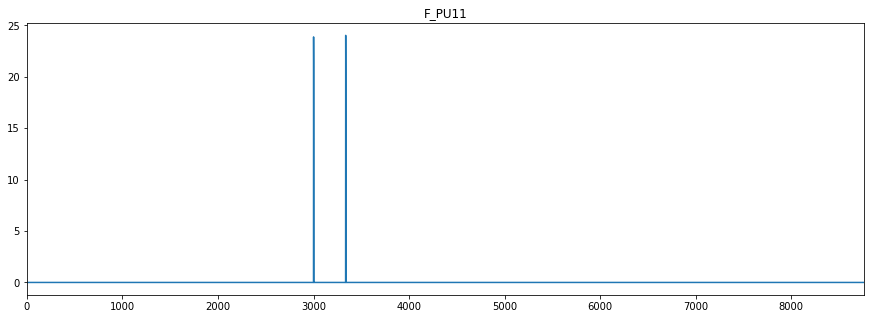

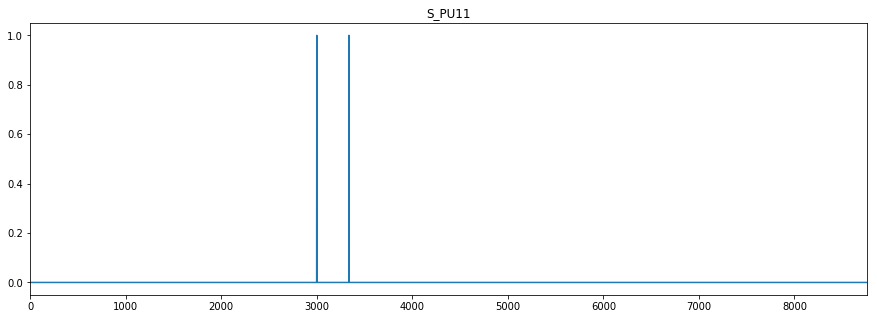

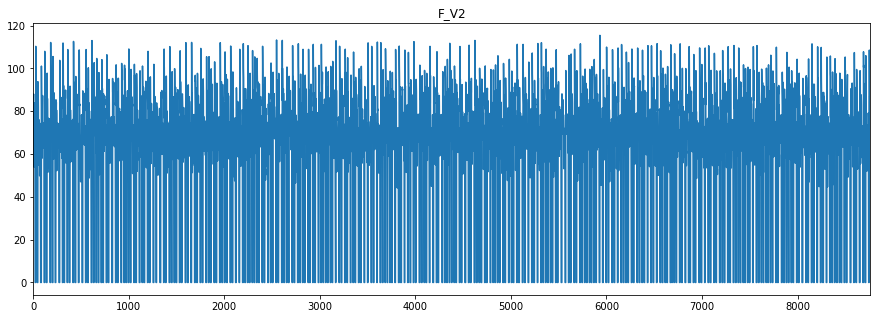

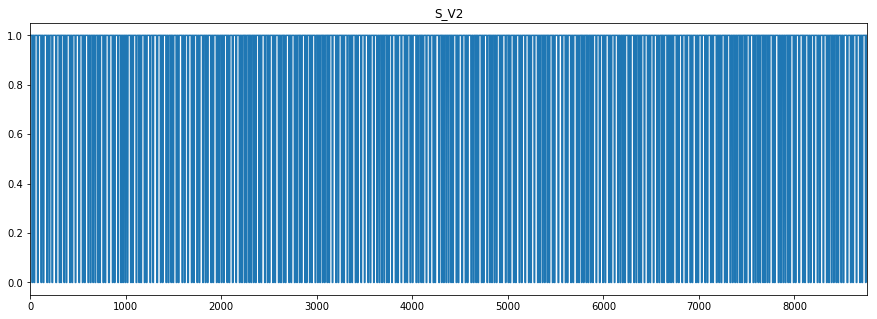

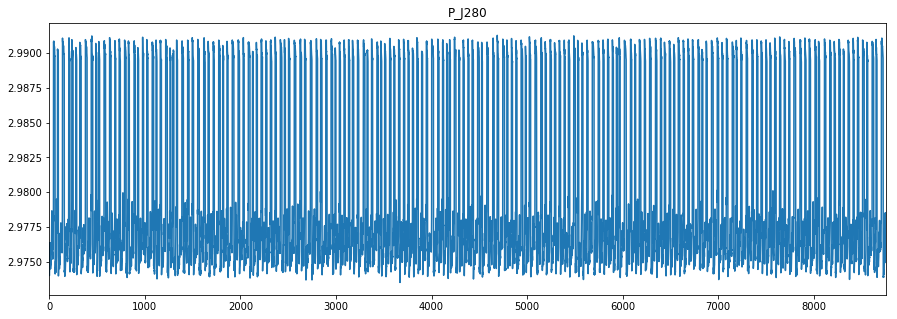

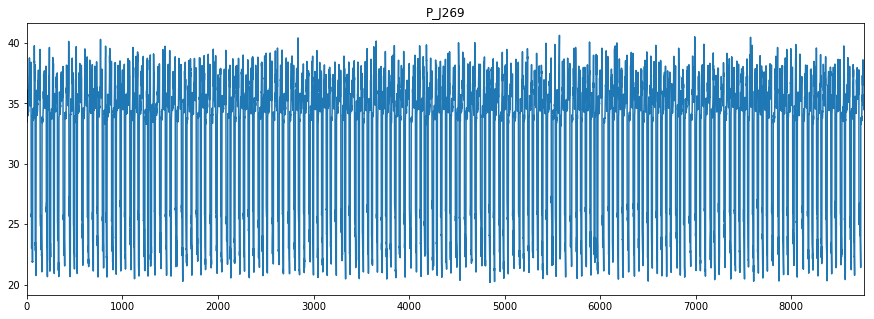

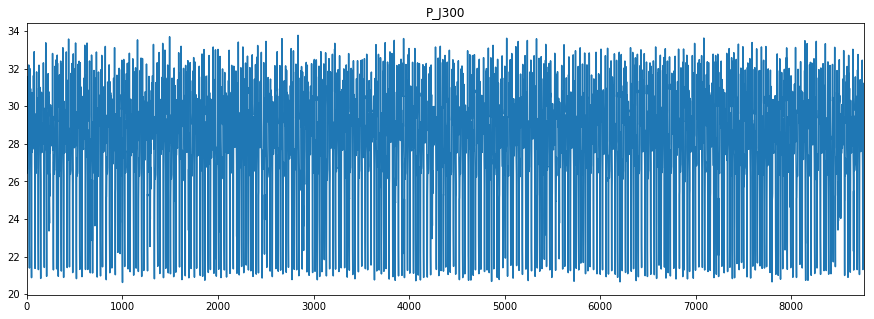

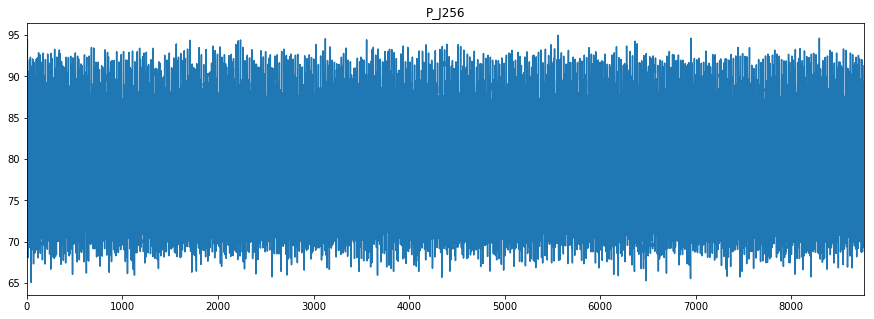

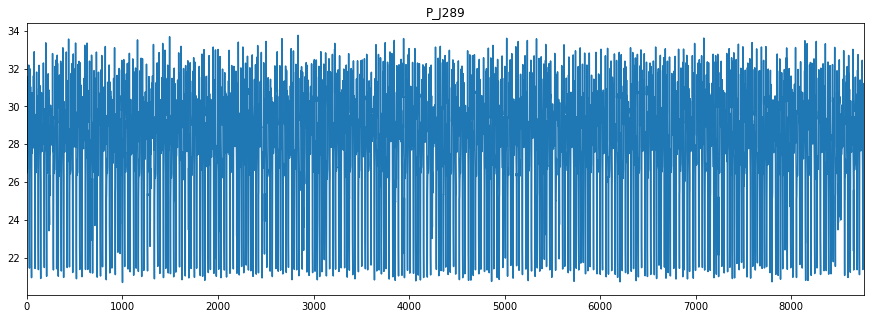

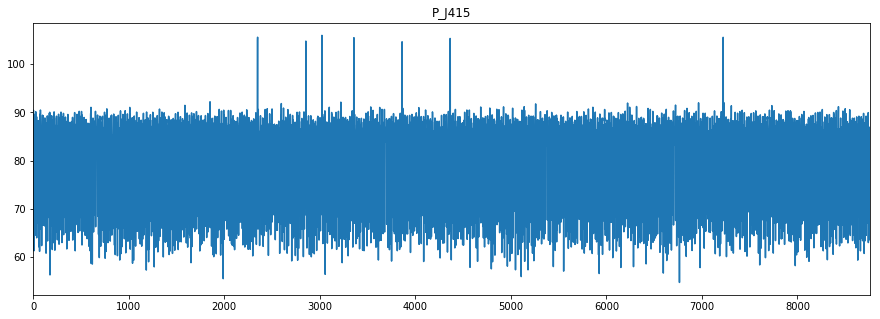

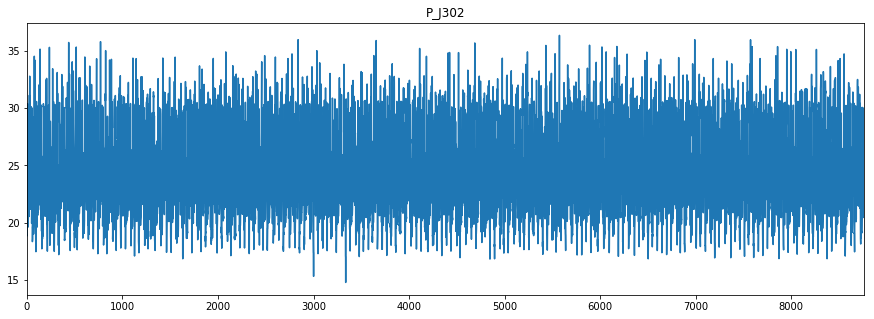

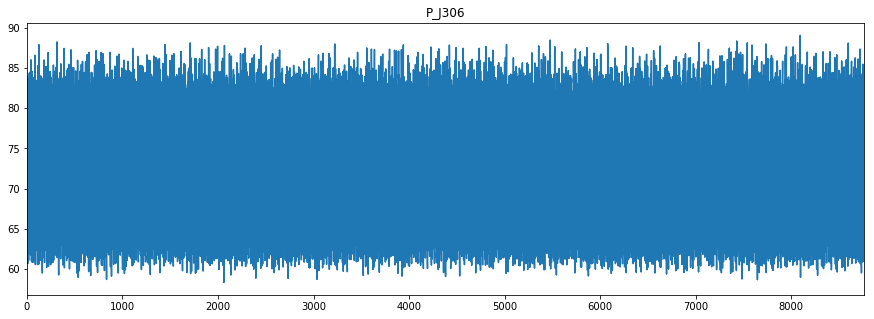

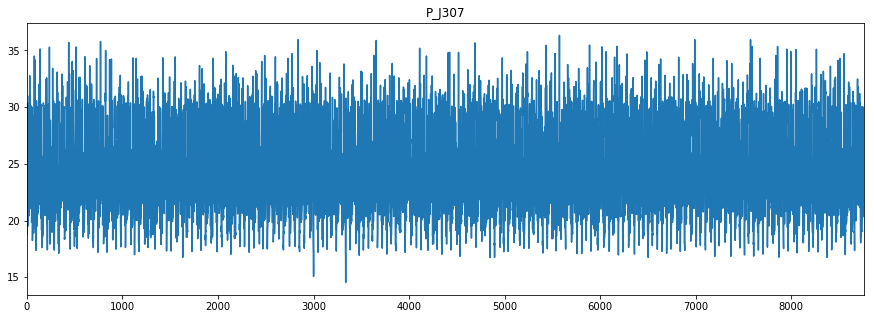

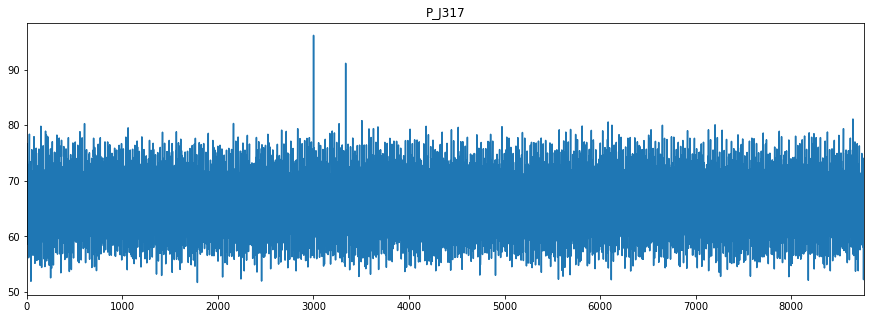

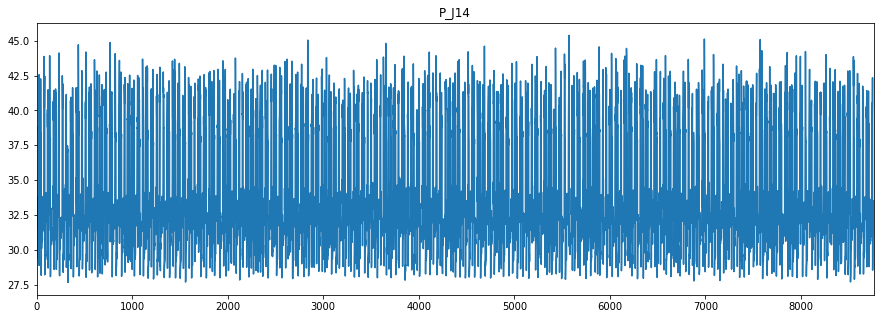

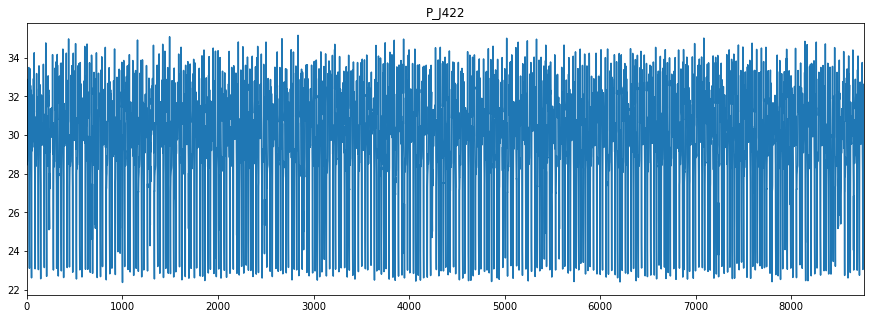

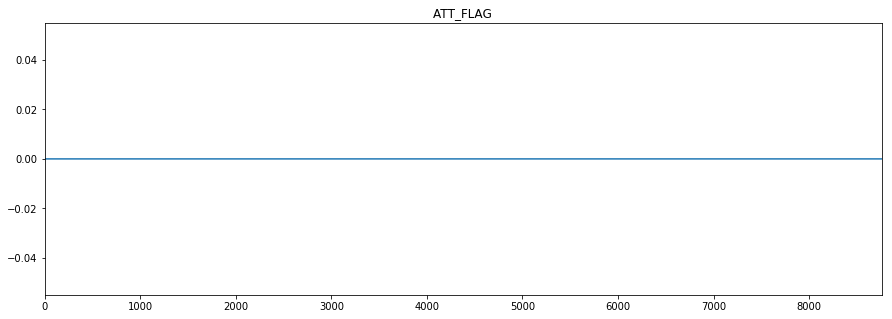

<Figure size 432x288 with 0 Axes>

In [56]:
for i, cl in enumerate(data.columns[1:]):
    plt.title(cl)
    data[cl].plot(figsize=(15,5))
    plt.show()
    plt.clf()

### Are the signals correlated? Do they show cyclic behavior?

As one can see in the correlation heatmap below there is some data correlated

The interesting ones for now are the correlations between actuators and sensors (not from the same machine). Taking the lowest and highest correlations <-1:-0.75> and <0.75:1> from the subset described gives some interesting plots. Although not all the time deltas are equal there is a clear cycle visible between waterlevels/flows/pressure and when actuators are activated

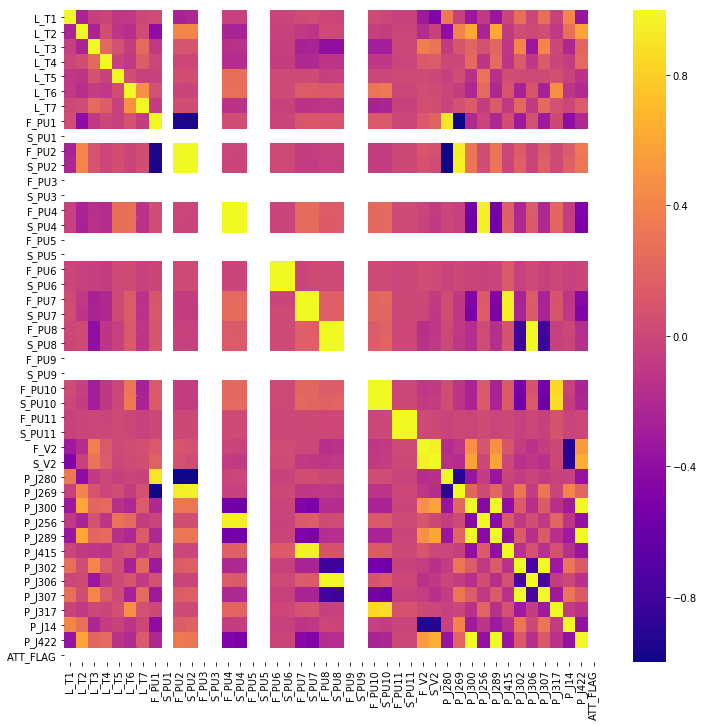

In [5]:
f, ax = plt.subplots(figsize=(12, 12))
corr = data.corr()
sns.heatmap(data.corr(), cmap='plasma')
plt.show()

In [57]:
cr_series = corr.unstack().sort_values(ascending=False).drop_duplicates().dropna()
cr = pd.DataFrame(cr_series)
cr['high'] = cr_series.between(-0.75, 0.75, inclusive=True)
cr = cr[cr['high']==False].drop('high', axis='columns').reset_index().set_axis(['x', 'y', 'correlation'], axis='columns', inplace=False)

# Filter correlations with itself
cr = cr[cr['x'] != cr['y']]

# Filter correlations between status and flow of same machine
cr = cr[cr['x'].str.split('_', expand=True)[1] != cr['y'].str.split('_', expand=True)[1]]

# Most interesting are the correlatiosn between sensors and actuators
cr = cr[(cr['x'].str.split('_', expand=True)[0] =='S') | (cr['y'].str.split('_', expand=True)[0]=='S')]

display(HTML(cr.to_html()))


,x,y,correlation
13,P_J306,S_PU8,0.989426
14,P_J269,S_PU2,0.962877
15,S_PU7,P_J415,0.960707
16,S_PU4,P_J256,0.958924
22,P_J317,S_PU10,0.861843
28,S_PU8,P_J307,-0.820805
29,S_PU8,P_J302,-0.823764
31,S_V2,P_J14,-0.919642
34,F_PU1,S_PU2,-0.961986
35,P_J280,S_PU2,-0.986258


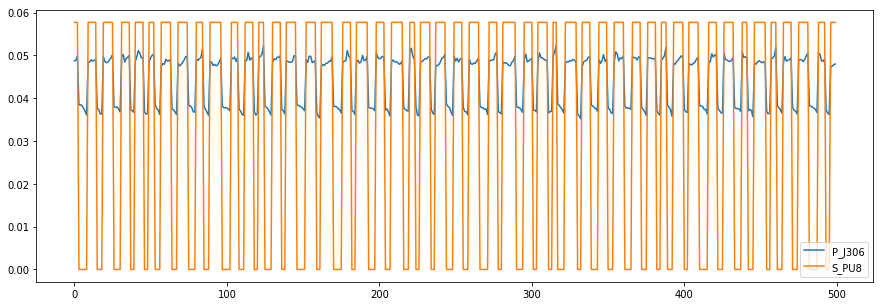

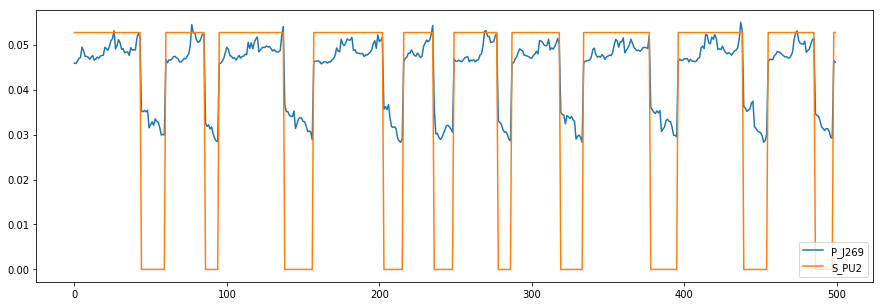

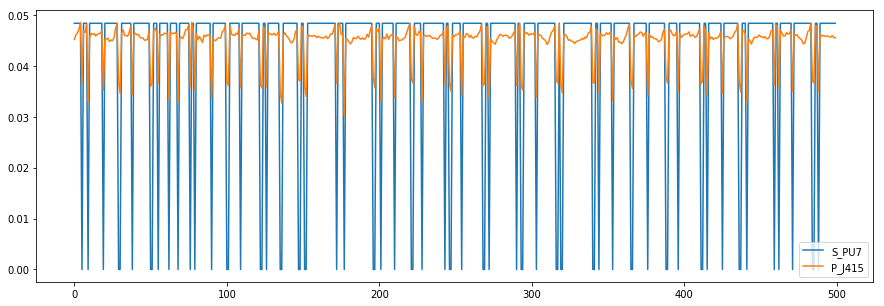

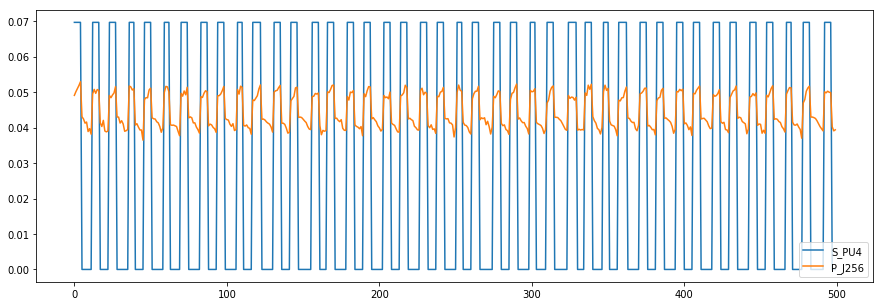

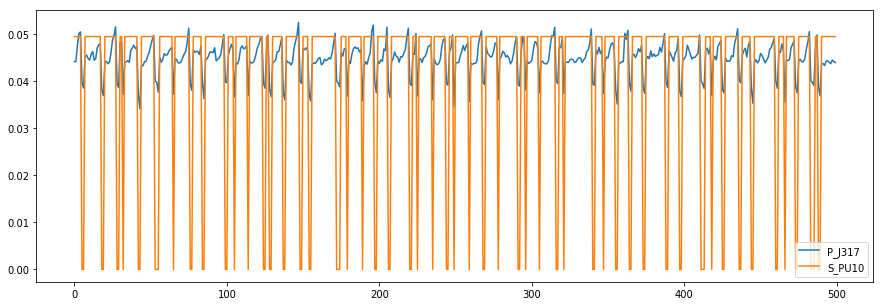

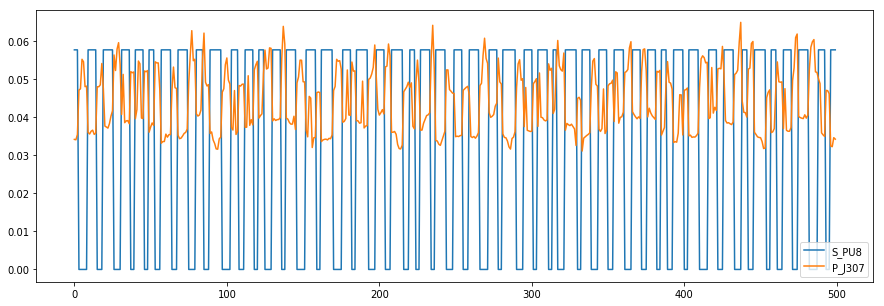

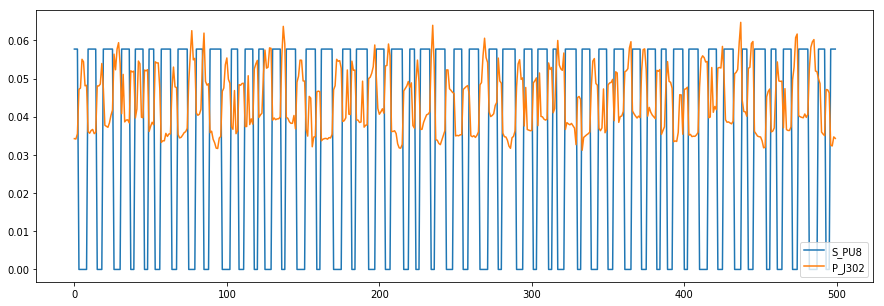

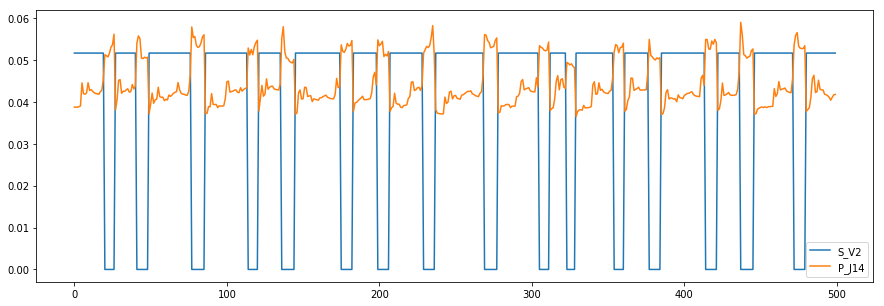

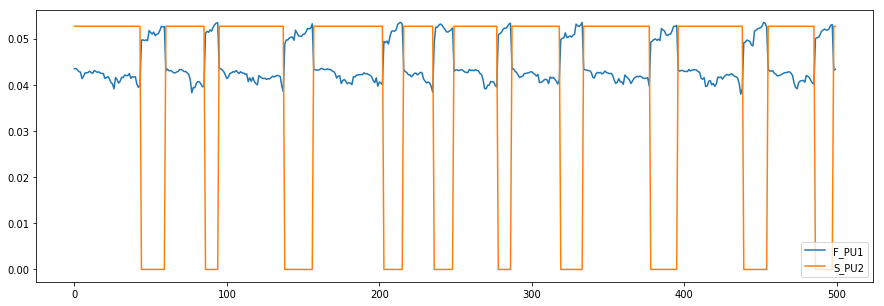

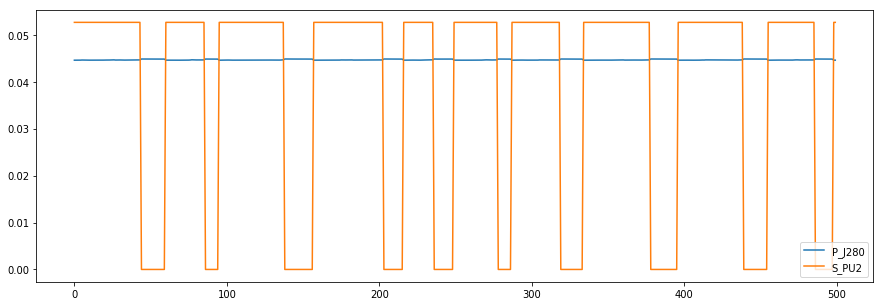

In [55]:
for row in cr.itertuples():
    plt.figure(figsize=(15,5))
    plt.plot(normalize(data[row[1]][:500].values.reshape(1, -1)).reshape(-1, 1), label=row[1])
    plt.plot(normalize(data[row[2]][:500].values.reshape(1, -1)).reshape(-1, 1), label=row[2])
    plt.legend(loc = 'lower right')
    plt.show()
#     plt.clf()

### Is predicting the next value in a series easy or hard? Use any method from class.

Using Auto regressive (AR)

// https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/

Test MSE: 21.223


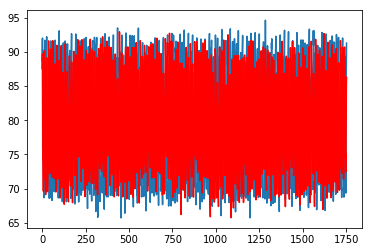

In [153]:
def predict(coef, history):
    #initialize on constant
    yhat = coef[0]
    # sum( phi(i) * X(t-1)) for i=1 till i=p
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

signal = 'P_J256'
train_size = int(len(data)*0.8)
train_data = data[signal][0:train_size]
test_data = data[signal][train_size:].reset_index(drop='true')
predictions = list()

# Order for AR
p=10
#Create and train model
model = AR(train_data)
model_fit = model.fit(p)
# Get coefficients (+ constant)
coef = model_fit.params
# Retreive last p points
history = train_data[-p:].to_list()

# Predict same amount as values as availale in test set
for t in range(len(test_data)):
    # predict next value and add to list
    yhat = predict(coef, history)
    predictions.append(yhat)
    
    # add original point to history for next prediction
    obs = test_data[t]
    history.append(obs)
    
error = mean_squared_error(test_data, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test_data)
plt.plot(predictions, color='red')
plt.show()

# ARMA task 

Learn an autoregressive moving average model for at least 5 individual sensors (pick them in a sensible way!). Most statistical packages (statsmodels in Python) contain standard algorithm for fitting these models from training data. Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using Akaike’s Information Criterion (AIC) or another model selection method. Note that there exists a wide range of ARMA variants; you only have to use the basic model. 

Decide how to set the detection threshold sensibly. Study some of the anomalies detected anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be modeled effectively using ARMA?

TODOS:
* Look at picking sensor data (now based on attack sheet)
* use autocorrelation to indetify order
* determine useing AIC
* Decide on threshold for attack
* write about this assignment
    

In [300]:
#  http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#ARMA

def predict(ar_coef, history, ma_coef, residuals):
    # AR: sum( phi(i) * X(t-1)) for i=1 till i=p
    # MA: sum( phi(i) * eps(t-1)) for i=1 till i=q (esp is residual error noise)
    yhat = 0
    for i in range(0, len(ar_coef)):
        yhat += ar_coef[i] * history[-i-1]
        
    for i in range(0, len(ma_coef)):
        yhat += ma_coef[i] * residuals[-i-1]
    return yhat

# p = order of AR     q = order of MA
def arma_predict(train_data, test_data, attack_data, feature_name, p=2, q=2, plot_start=-1, plot_end=-1):
    model = ARMA(train_data, (p,q))
    model_fit = model.fit()
    ar_coef = model_fit.arparams
    ma_coef = model_fit.maparams

    history = train_data[-p:].to_list()
    residuals = model_fit.resid[-q:].to_list()
    predictions = list()

    # Predict same amount as values as availale in test set
    for i in range(len(data2)):
        # predict next value and add to list
        yhat = predict(ar_coef, history, ma_coef, residuals)
        predictions.append(yhat)

        # add original point to history for next prediction
        obs = test_data[i]
        history.append(obs)
        residuals.append(obs-yhat)

    #  remove initializations residuals
    residuals = residuals[q:]

    start = plot_start if plot_start>-1 else 0
    end = plot_end if plot_end> -1 and plot_end > plot_start else len(residuals)

    # corrfect for the avarage of the residuals. Since this is the error between original and prediction we want to shift it for half
    residuals = pd.DataFrame(residuals-0.5*np.mean(residuals))

    # plot
    plt.figure(figsize=(15,5))
    plt.plot(test_data[start:end], color='blue')
    plt.plot(residuals[start:end], color='green')
    plt.plot(attack_data[start:end], color='red')
    axes=plt.gca()
    axes.set_ylim((-100, 150))
    plt.legend(['original signal', 'predicted signal', 'attack flag'])
    plt.title('ARMA prediction attack on: '+feature_name)
    plt.show()

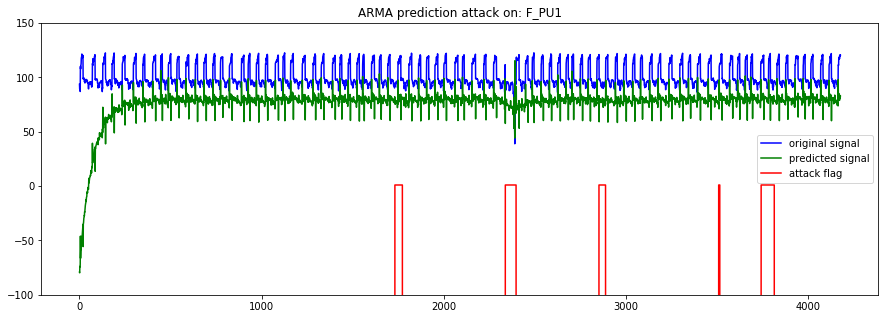

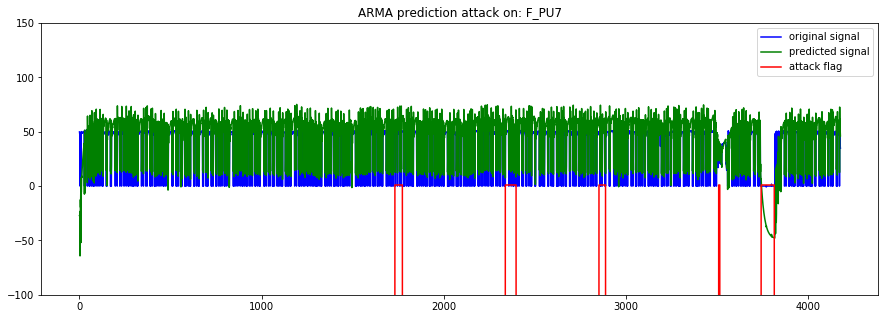

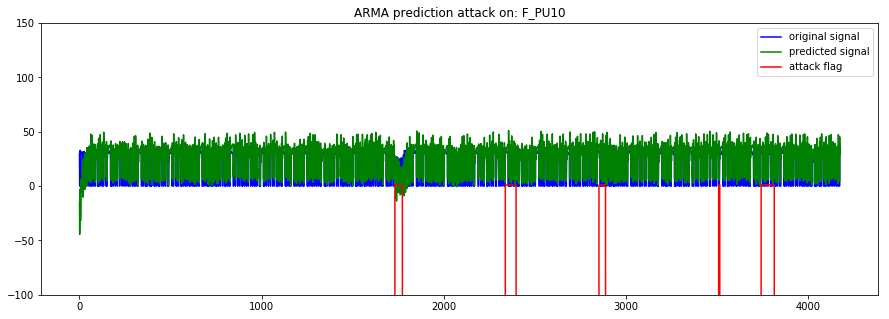

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


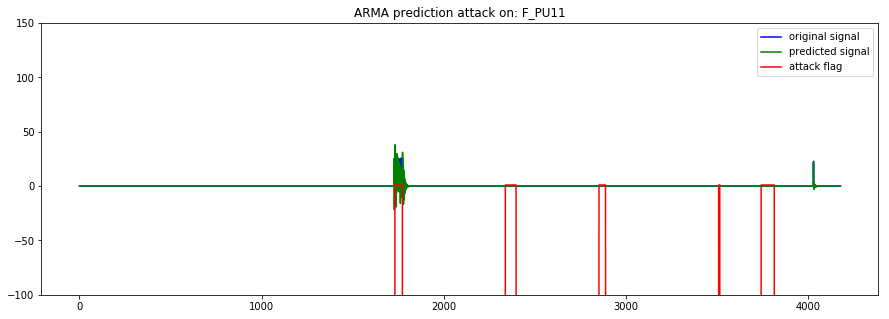

In [306]:
signal = ['F_PU1', 'F_PU7', 'F_PU10', 'F_PU11']

for sig in signal:
    arma_predict(data[sig], data2[sig], data2['ATT_FLAG'], sig, p=3, q=3)

# Discrete models task

Discretize the sensor data using any of the methods discussed in class. Explain why you choose this method and why the obtained discretization makes sense. Visualize the discretization. 

Apply any of the sequential data mining methods (N-grams, Sequence alignment with kNN, …) to sliding windows with a length of your choosing in order to find anomalies. Whenever an observed Ngram’s probability is too small, or the sequential data is too distant from any training sequence, raise an alarm. Set your thresholds sensibly. What kind of anomalies can you detect using the sequential model? Which sensors can be modeled effectively?

# PCA task

Perform PCA-based anomaly detection on the signal data. Set the threshold on training data to a value that results in few false positives on the training data. Plot the PCA residuals in one signal. Do you see large abnormalities in the training data? Can you explain why these occur? It is best to remove such abnormalities from the training data since you only want to model normal behavior. What kind of anomalies can you detect using PCA?

# Comparison task

Compare the performance of the PCA method with the ARMA and discrete models. Comparing anomaly detection methods in not straightforward, and different research studies frequently use different measures. You can either:
* test point-wise precision and recall, or
* overlap-based false and true positives, or /and
* count a true positive if it detects at least one anomaly in an anomalous region, or
* compare the top-k detected anomalies,
* or...

Describe in a few lines which comparison method you chose for this data and why. Keep in mind that
in practice an analyst has to take action on every positive detected, but will not study every detected
data point. Do you recommend using PCA, ARMA, or discrete models?

# Bonus task

Use PyTorch (or another framework) to learn Deep Neural Networks for anomaly detection as discussed in class and in the literature. Try out different learning rates and detection thresholds. Compare the performance with the three approaches tested above. Do you recommend using Deep Learning? Why (not)?